# Limit order book (LOB) simulation

Using [Bouchaud et al. (2018)](https://doi.org/10.1017/9781316659335) as the main reference here.

Also look at [Blanc, Donier & Bouchaud (2015)](https://doi.org/10.1080/14697688.2016.1193215) for the right Hawkes process ideas.

The simulation of financial markets through the use of agent-based models is an increasingly popular technique to understand the microstructure of their dynamics from the bottom up. In this notebook, we'll look at an example market simulation.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Get the class structures
import sys
sys.path.append("/Users/Rob/work/finmarbs/utils/")
from lobsim import LOBsim
from sfagent import SFagentens

Begin with a **heterogeneous individual-agent** version of the original **Santa Fe model** using a synchronous ensemble rejection algorithm. The key point here is to make sure the overall holding rate is large enough which should limit the number of anachronisms in the order flow...

In [6]:
def exotrendfunc(r, t):
    r = np.sin(np.pi * 0.1 * t) 
    return r

setup = {
    # Number of agents
    "Nagents" : 100,
    # 1/variance in agent relative trading rates
    "heterok" : 0.1,
    # Mean global agent speculation rate
    "meanspecrate" : 1.0,
    # Mean limit order rate per agent on the bid side
    "meanLOratebid" : 3.0,
    # Mean limit order rate per agent on the ask side
    "meanLOrateask" : 3.0,
    # Initial exogeneous trend
    "initexotrend" : 0.5,
    # Exogeneous trend function
    "exotrendfunc" : exotrendfunc,
    # Mean market order rate per agent on the bid side
    "meanMOratebid" : 0.3,
    # Mean market order rate per agent on the ask side
    "meanMOrateask" : 0.3,
    # Mean cancel order rate per agent on the bid side
    "meanCOratebid" : 0.1,
    # Mean cancel order rate per agent on the ask side
    "meanCOrateask" : 0.1,
    # The overall mean holding rate
    "meanHOrate" : 100.0,
    # Limit order decay power in price units
    "LOdecay" : 0.1,
    # Initial bid tick
    "initbidpricetick" : 100,
    # Initial ask tick
    "initaskpricetick" : 101,
    # The price tick size
    "tickscale" : 1.0,
    # The number of price points simulated
    "Nlattice" : 200,
    # Hawkes kernel power for endogeneous excitations
    "Hawkespow" : 1.0,
    # Trader behaviour ratio between endogeneous vs exogeneous
    "rbehaviours" : 1.0 #- (0.1 * np.random.uniform(size=100)),
}

# Initialise the LOB simulation
los = LOBsim(setup, agentens=SFagentens)

# Iterate the LOB over time
tend, t = 100.0, 0.0
midps = []
while t < tend:
    los.iterate()
    t = los.time
    midps.append([t, los.market_state_info["midprice"]])

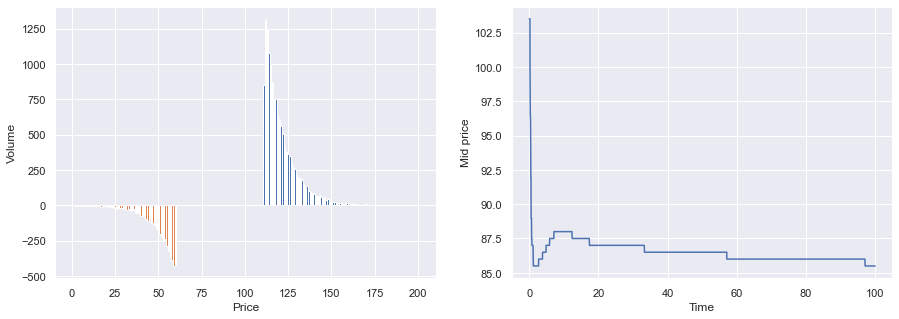

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].bar(los.prices, los.asks)
ax[0].bar(los.prices, -los.bids)
ax[1].plot(np.asarray(midps)[:, 0], np.asarray(midps)[:, 1])
ax[0].set_ylabel('Volume')
ax[0].set_xlabel('Price')
ax[1].set_ylabel('Mid price')
ax[1].set_xlabel('Time')
plt.show()

The master equation for the process above at price $p$ is

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}P(\dots, V^p_{ib}, \dots, V^p_{ia}, \dots, t) &= \frac{1}{2}\sum_{\forall i}\gamma_i\lambda^p_b(t) P(\dots, V^p_{ib}-1, \dots, V^p_{ia}, \dots, t) \\
&+ \frac{1}{2}\sum_{\forall i}\gamma_i\lambda^p_a(t) P(\dots, V^p_{ib}, \dots, V^p_{ia}-1, \dots, t) \\
&+ \frac{1}{2}\sum_{\forall i}\frac{(V^p_{ib}+1)\sum_{\forall i'}\gamma_{i'}\mu^p_b(t)}{1+\sum_{\forall i'}V^p_{i'b}} P(\dots, V^p_{ib}+1, \dots, V^p_{ia}, \dots, t) \\
&+ \frac{1}{2}\sum_{\forall i}\frac{(V^p_{ia}+1)\sum_{\forall i'}\gamma_{i'}\mu^p_a(t)}{1+\sum_{\forall i'}V^p_{i'a}} P(\dots, V^p_{ib}, \dots, V^p_{ia}+1, \dots, t) \\
&+ \frac{1}{2}\sum_{\forall i}(V^p_{ib}+1)\gamma_i\nu_b(t) P(\dots, V^p_{ib}+1, \dots, V^p_{ia}, \dots, t) \\
&+ \frac{1}{2}\sum_{\forall i}(V^p_{ia}+1)\gamma_i\nu_a(t) P(\dots, V^p_{ib}, \dots, V^p_{ia}+1, \dots, t) \\
&- \frac{1}{2}\sum_{\forall i}
\bigg\{ \gamma_i\lambda^p_b(t) + \gamma_i\lambda^p_a(t) + \gamma_i\mu^p_b(t) + \gamma_i\mu^p_a(t) + V^p_{ib}\gamma_i\nu_b(t) + V^p_{ia}\gamma_i\nu_a(t) \bigg\} P(\dots, V^p_{ib}, \dots, V^p_{ia}, \dots, t)\,,
\end{align}
$$

where $m(t)=[b(t)+a(t)]/2$ is the mid price and the other functions are

$$
\begin{equation}
\lambda^p_b(t) = \lambda_b(t) \mathbb{1}_{b(t)\geq p} e^{-\alpha [m(t)-p]}\,, \quad \lambda^p_a(t) = \lambda_a(t) \mathbb{1}_{p\geq a(t)} e^{-\alpha [p-m(t)]}\,, \quad \mu^p_b(t) = \mu_b(t) \mathbb{1}_{a(t)= p}\,, \quad \mu^p_a(t) = \mu_a(t) \mathbb{1}_{b(t)= p} \,,
\end{equation}
$$

where: $\lambda_b(t)\,, \lambda_a(t)$ are the average limit order rates per agent; $\alpha$ is the limit order decay power; $\mu_b(t)\,, \mu_a(t)$ are the average market order rates per agent; $\nu_b(t)\,, \nu_a(t)$ are the average order-cancellation rates per agent; and $\gamma_i$ is the $i$-th agents' preferred relative trading rate, which we draw from a unit-mean and $1/k$-variance gamma distribution, i.e., ${\rm PDF}(\gamma_i)={\rm Gamma}(\gamma_i;k,k)$. Note that we denote $\mathbb{1}_A$ as an indicator function which takes value unity when $A$ is true, else 0.

Let us now approximate the terms $1+\sum_{\forall i'}V^p_{i'a}$ and $1+\sum_{\forall i'}V^p_{i'b}$ in the denominator of the market order rate coefficients for the $i$-th agent to be the time-dependent stochastic processes $F^p_{a}(t)$ and $F^p_{b}(t)$ which are uncorrelated to the $i$-th agent's actions. By then marginalising over the full master equation bid and ask volumes $\forall i'\neq i$, we can hence obtain an approximate equation for each individual agent

$$
\begin{align}
\frac{{\rm d}}{{\rm d}t}P(V^p_{ib}, V^p_{ia}, t) &\simeq \frac{1}{2}\gamma_i\lambda^p_b(t) P(V^p_{ib}-1, V^p_{ia}, t) + \frac{1}{2}\gamma_i\lambda^p_a(t) P(V^p_{ib}, V^p_{ia}-1, t) \\
&+ \sum_{\forall i'}\gamma_{i'}\mu^p_b(t) \frac{(V^p_{ib}+1)}{2F^p_{b}(t)}P(V^p_{ib}+1, V^p_{ia}, t) + \sum_{\forall i'}\gamma_{i'}\mu^p_a(t) \frac{(V^p_{ia}+1)}{2F^p_{a}(t)}P(V^p_{ib}, V^p_{ia}+1, t) \\
&+ \frac{1}{2}(V^p_{ib}+1)\gamma_i\nu_b(t) P(V^p_{ib}+1, V^p_{ia}, t) + \frac{1}{2}(V^p_{ia}+1)\gamma_i\nu_a(t) P(V^p_{ib}, V^p_{ia}+1, t) \\
&- \frac{1}{2}
\bigg\{ \gamma_i\lambda^p_b(t) + \gamma_i\lambda^p_a(t) + \sum_{\forall i'}\gamma_{i'}\mu^p_b(t) \frac{V^p_{ib}}{2F^p_{b}(t)} + \sum_{\forall i'}\gamma_{i'}\mu^p_a(t) \frac{V^p_{ia}}{2F^p_{a}(t)} + V^p_{ib}\gamma_i\nu_b(t) + V^p_{ia}\gamma_i\nu_a(t) \bigg\} P(V^p_{ib}, V^p_{ia}, t)\,.
\end{align}
$$

Taking the first moments of this equation with respect to $V^p_{ia}$ and $V^p_{ib}$ in turn, we then obtain the probability mass function solution of two independent time-inhomogeneous Poisson processes

$$
\begin{align}
P(V^p_{ib}, V^p_{ia}, t) &\simeq {\rm Poisson}\big[ V^p_{ib};{\rm E}_{t}(V^p_{ib})\big] {\rm Poisson}\big[ V^p_{ia};{\rm E}_{t}(V^p_{ia})\big] \\
{\rm E}_{t}(V^p_{ib}) &\simeq {\rm E}_{t_0}(V^p_{ib})\exp \bigg\{ - \int_{t_0}^t \frac{\sum_{\forall i'}\gamma_{i'}\mu^p_b(t')}{2F^p_{b}(t')}{\rm d}t' - \frac{1}{2}\int_{t_0}^t\gamma_i\nu_b(t'){\rm d}t'\bigg\} \\
&+  \frac{1}{2}\int_{t_0}^t {\rm d}t' \gamma_i\lambda^p_b(t') \exp \bigg\{ - \int_{t'}^t \frac{\sum_{\forall i'}\gamma_{i'}\mu^p_b(t'')}{2F^p_{b}(t'')}{\rm d}t'' - \frac{1}{2}\int_{t'}^t\gamma_i\nu_b(t''){\rm d}t''\bigg\} \\
{\rm E}_{t}(V^p_{ia}) &\simeq {\rm E}_{t_0}(V^p_{ia})\exp \bigg\{ - \int_{t_0}^t \frac{\sum_{\forall i'}\gamma_{i'}\mu^p_a(t')}{2F^p_{a}(t')}{\rm d}t' - \frac{1}{2}\int_{t_0}^t\gamma_i\nu_a(t'){\rm d}t'\bigg\} \\
&+  \frac{1}{2}\int_{t_0}^t {\rm d}t' \gamma_i\lambda^p_a(t') \exp \bigg\{ - \int_{t'}^t \frac{\sum_{\forall i'}\gamma_{i'}\mu^p_a(t'')}{2F^p_{a}(t'')}{\rm d}t'' - \frac{1}{2}\int_{t'}^t\gamma_i\nu_a(t''){\rm d}t''\bigg\} \,.
\end{align}
$$

Note that by summing over $i$, we obtain an approximate description of the volume queue at each price $p$. Furthermore, we may infer that the probabilities for a price having non-zero bid or ask volume, respectively, at time $t$ are given by

$$
\begin{equation}
P(V^p_{b}>0, t) = 1-e^{-\sum_{\forall i}{\rm E}_{t}(V^p_{ib})}\,, \qquad P(V^p_{a}>0, t) = 1-e^{-\sum_{\forall i}{\rm E}_{t}(V^p_{ia})}\,.
\end{equation}
$$

Note also that as the distribution approaches stationarity, the distributions over the sum of agent volumes $\sum_{\forall i}V^p_{ib}$ and $\sum_{\forall i}V^p_{ia}$ for a given price are also approximately Poisson (since there is an overall cancellation of the gamma-distributed factor in the second integrals within the expressions above).

Model improvements/extensions to consider:
1. Mutually self-exciting processes to deal with endogeneous effects, like event clustering. This can be done via the market orders depending on the recent change in volume via a Hawkes process kernel $\Phi$, i.e., something like $\gamma_i\mu_b(t){\rm d}t \rightarrow r_i\gamma_i\mu_b(t){\rm d}t + (1-r_i)\Phi (t-t')\sum_{\forall i}{\rm d}V^{a}_{ib}(t')/N_{\rm agents}$, where $r_i$ is a ratio which governs how much an the $i$-th trader's behaviour is exogeneously determined through fundamental price changes versus being more endogeneously determined through self-excitations. Note that we can approximate $\sum_{\forall i}{\rm d}V^p_{ib}(t) \simeq {\rm d}F^p_{b}(t) \simeq \big\{ {\rm E}[F^p_{b}(t)] - F^p_{b}(t)\big\} q{\rm d}t + {\rm Var}[F^p_{b}(t)]^{1/2}q^{1/2}{\rm d}W(t)$ where $q$ is some mean-reversion rate to think about.
2. Available-volume-dependent market order rates, e.g., $\mu_b(t)\rightarrow \mu_b\big( t, \sum_{\forall i}V^p_{ib}\big)$.
3. Order flows that are **not** independent from one-another. E.g., include the long-range autocorrelation of market order signs. Also, market orders tend to be followed by limit orders which restore the depleted queue.

Analyses to perform:
1. Try to derive a theory for the time evolution of the mid price
2. Extended master equation to account for all of the above effects
3. A large-$N$ expansion and derive some jump-diffusion equations based on temporal scales
4. Bayesian analysis and inference of the market using mock data generated with the simulator using a general model with the above suggestions and either derivatives of the likelihood from the ODE using the multiple-adjoint method or an ABC emulator method
5. Bayesian analysis and inference of the market using mock data generated with the simulator using a geometric Brownian motion model for the mid price only to mimic Black-Scholes risk calibration

## Bayesian agent extensions to the Santa Fe model

In this section we will build cleverer agents in a new class to place within the above market simulation - these are Bayesian agents who treat the market like a geometric Brownian motion and try to infer price movements from this and mock correlated markets. They will also seek to maximise their respective log-returns over time using this inferred knowledge via an dynamic hedging strategy given their internal models.